https://github.com/iamaaditya/neural-paraphrase-generation/tree/dev/data

https://github.com/Deep1994/seq2seq-keras/tree/master/dataset

https://medium.com/nlplanet/a-full-guide-to-finetuning-t5-for-text2text-and-building-a-demo-with-streamlit-c72009631887

# Setup

This project requires Python 3.7 or above:

In [1]:
import sys

assert sys.version_info >= (3, 7)

And TensorFlow ≥ 2.8:

In [2]:
import tensorflow as tf

assert tf.__version__ >= "2.8.0"

# Downloading the Data

In [6]:
!wget http://cs.jhu.edu/~vandurme/data/parabank-1.0-5m-diverse.zip
!unzip parabank-1.0-5m-diverse.zip 

--2022-07-03 03:41:05--  http://cs.jhu.edu/~vandurme/data/parabank-1.0-5m-diverse.zip
Resolving cs.jhu.edu (cs.jhu.edu)... 128.220.13.64
Connecting to cs.jhu.edu (cs.jhu.edu)|128.220.13.64|:80... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://www.cs.jhu.edu/~vandurme/data/parabank-1.0-5m-diverse.zip [following]
--2022-07-03 03:41:05--  https://www.cs.jhu.edu/~vandurme/data/parabank-1.0-5m-diverse.zip
Resolving www.cs.jhu.edu (www.cs.jhu.edu)... 128.220.13.64
Connecting to www.cs.jhu.edu (www.cs.jhu.edu)|128.220.13.64|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 279732141 (267M) [application/zip]
Saving to: ‘parabank-1.0-5m-diverse.zip.1’

parabank-1.0-5m-div 100%[===================>] 266.77M  87.0MB/s    in 3.2s    

2022-07-03 03:41:08 (82.7 MB/s) - ‘parabank-1.0-5m-diverse.zip.1’ saved [279732141/279732141]

Archive:  parabank-1.0-5m-diverse.zip
replace parabank-1.0-small-diverse/parabank.5m.meta? [y]es, [n]o, 

In [3]:
text=open('parabank-1.0-small-diverse/parabank.5m.tsv','r').read()

# Preprocessing

In [4]:
import numpy as np

text = text.replace("¡", "").replace("¿", "")
pairs = [line.split("\t") for line in text.splitlines()]
np.random.seed(42)  
np.random.shuffle(pairs)
sentences_en, sentences_es = zip(*pairs)  

In [5]:
sentences_en[0] , sentences_es[0]

('The debtor institution is consequently obliged to accept the information on which the claim is based and to reimburse the claim .',
 'The debtor institution is subsequently required to accept the information on which the claim is based and to pay it .')

In [6]:
del pairs,text

In [7]:
len(sentences_en)

5000000

In [ ]:
sentences_en=sentences_en[:100000]
sentences_es=sentences_es[:100000] 

In [ ]:
for i in range(3,6):
    print(sentences_en[i], "=>", sentences_es[i])

See you . => Thanks , Olga . See you .
I ca n't write that shit . => I ca n't do shit like that .
Warren , Warren , Warren , Warren ! => Oh , Warren , Warren , Warren , Warren !


In [ ]:
vocab_size = 3000
max_length = 20
text_vec_layer_en = tf.keras.layers.TextVectorization(
    vocab_size, output_sequence_length=max_length)
text_vec_layer_es = tf.keras.layers.TextVectorization(
        vocab_size, output_sequence_length=max_length)
text_vec_layer_en.adapt(sentences_en)
text_vec_layer_es.adapt([f"startofseq {s} endofseq" for s in sentences_es])

In [ ]:
len(text_vec_layer_en.get_vocabulary())

3000

In [ ]:
text_vec_layer_en.get_vocabulary()[:10]

['', '[UNK]', 'the', 'of', 'to', 'you', 'i', 'and', 'in', 'a']

In [ ]:
text_vec_layer_es.get_vocabulary()[:10]

['', '[UNK]', 'startofseq', 'endofseq', 'the', 'of', 'to', 'you', 'i', 'and']

In [ ]:
text_vec_layer_en(['Symptoms of influenza include fever and nasal congestion'])

<tf.Tensor: shape=(1, 20), dtype=int64, numpy=
array([[1242,    3,    1,  460, 2717,    7,    1,    1,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0]])>

In [ ]:
X_train = tf.constant(sentences_en[:80000])
X_valid = tf.constant(sentences_en[80000:90000])
X_test  = tf.constant(sentences_en[90000:])

X_train_dec = tf.constant([f"startofseq {s}" for s in sentences_es[:80000]])
X_valid_dec = tf.constant([f"startofseq {s}" for s in sentences_es[80000:90000]])
X_test_dec = tf.constant([f"startofseq {s}" for s in sentences_es[90000:]])

Y_train = text_vec_layer_es([f"{s} endofseq" for s in sentences_es[:80000]])
Y_valid = text_vec_layer_es([f"{s} endofseq" for s in sentences_es[80000:90000]])
Y_test = text_vec_layer_es([f"{s} endofseq" for s in sentences_es[90000:]])

In [ ]:
X_train.shape,X_valid.shape,X_train_dec.shape,X_valid_dec.shape,Y_train.shape,Y_valid.shape

(TensorShape([8000]),
 TensorShape([2000]),
 TensorShape([8000]),
 TensorShape([2000]),
 TensorShape([8000, 20]),
 TensorShape([2000, 20]))

In [ ]:
del sentences_en, sentences_es

# Encoder Decoder Model

## Using Standard RNN's

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU
encoder_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)
decoder_inputs = tf.keras.layers.Input(shape=[], dtype=tf.string)

In [ ]:
embed_size = 256
encoder_input_ids = text_vec_layer_en(encoder_inputs)
decoder_input_ids = text_vec_layer_en(decoder_inputs)
encoder_embedding_layer = tf.keras.layers.Embedding(vocab_size, embed_size,
                                                    mask_zero=True)
decoder_embedding_layer = tf.keras.layers.Embedding(vocab_size, embed_size,
                                                    mask_zero=True)
encoder_embeddings = encoder_embedding_layer(encoder_input_ids)
decoder_embeddings = decoder_embedding_layer(decoder_input_ids)

In [ ]:
encoder = tf.keras.layers.LSTM(512, return_state=True)
encoder_outputs, *encoder_state = encoder(encoder_embeddings)

In [ ]:
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)

In [ ]:
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
Y_proba = output_layer(decoder_outputs)

In [ ]:
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train, epochs=10,batch_size=32,
          validation_data=((X_valid, X_valid_dec), Y_valid))                    

Epoch 1/10
250/250 [==============================] - 15s 33ms/step - loss: 1.6464 - accuracy: 0.4151 - val_loss: 2.1482 - val_accuracy: 0.3618
Epoch 2/10
250/250 [==============================] - 6s 23ms/step - loss: 1.5039 - accuracy: 0.4363 - val_loss: 2.1589 - val_accuracy: 0.3664
Epoch 3/10
250/250 [==============================] - 6s 24ms/step - loss: 1.3902 - accuracy: 0.4593 - val_loss: 2.1789 - val_accuracy: 0.3729
Epoch 4/10
250/250 [==============================] - 6s 24ms/step - loss: 1.2774 - accuracy: 0.4849 - val_loss: 2.2061 - val_accuracy: 0.3758
Epoch 5/10
250/250 [==============================] - 6s 23ms/step - loss: 1.1684 - accuracy: 0.5153 - val_loss: 2.2392 - val_accuracy: 0.3816
Epoch 6/10
250/250 [==============================] - 6s 24ms/step - loss: 1.0611 - accuracy: 0.5470 - val_loss: 2.2772 - val_accuracy: 0.3785
Epoch 7/10
250/250 [==============================] - 6s 24ms/step - loss: 0.9588 - accuracy: 0.5836 - val_loss: 2.3106 - val_accuracy: 0.383

In [ ]:
model.evaluate((X_test,X_test_dec),Y_test,batch_size=32)

In [ ]:
def translate(sentence_en):
    translation = ""
    for word_idx in range(max_length):
        X = np.array([sentence_en])  # encoder input 
        X_dec = np.array(["startofseq " + translation])  # decoder input
        y_proba = model.predict((X, X_dec))[0, word_idx]  # last token's probas
        predicted_word_id = np.argmax(y_proba)
        predicted_word = text_vec_layer_es.get_vocabulary()[predicted_word_id]
        if predicted_word == "endofseq":
            break
        translation += " " + predicted_word
    return translation.strip()

In [ ]:
translate("Symptoms of influenza include fever and nasal congestion.")

'13 of arab countries and [UNK] [UNK] [UNK]'

In [ ]:
translate("where are you from")

'where are you feeling'

Nice! However, the model struggles with longer sentences:

In [ ]:
translate("QuillBot's paraphraser takes your sentences and makes changes, helping you to rework and rephrase your content quickly and efficiently!")

'[UNK] [UNK] the [UNK] and sent you [UNK] to [UNK] [UNK] and [UNK] and [UNK] s voice'

## Bidirectional RNNs

To create a bidirectional recurrent layer, just wrap a regular recurrent layer in a `Bidirectional` layer:

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU
encoder = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(256, return_state=True))

In [ ]:
encoder_outputs, *encoder_state = encoder(encoder_embeddings)
encoder_state = [tf.concat(encoder_state[::2], axis=-1),  # short-term (0 & 2)
                 tf.concat(encoder_state[1::2], axis=-1)]  # long-term (1 & 3)

In [ ]:
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")

Y_proba = output_layer(decoder_outputs)
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])

model.fit((X_train, X_train_dec), Y_train, epochs=10,batch_size=32,
          validation_data=((X_valid, X_valid_dec), Y_valid))

Epoch 1/10
250/250 [==============================] - 23s 43ms/step - loss: 2.5924 - accuracy: 0.2452 - val_loss: 2.3914 - val_accuracy: 0.2958
Epoch 2/10
250/250 [==============================] - 7s 29ms/step - loss: 2.1082 - accuracy: 0.3370 - val_loss: 2.1976 - val_accuracy: 0.3354
Epoch 3/10
250/250 [==============================] - 7s 30ms/step - loss: 1.8646 - accuracy: 0.3868 - val_loss: 2.0985 - val_accuracy: 0.3615
Epoch 4/10
250/250 [==============================] - 7s 28ms/step - loss: 1.6784 - accuracy: 0.4240 - val_loss: 2.0391 - val_accuracy: 0.3801
Epoch 5/10
250/250 [==============================] - 7s 29ms/step - loss: 1.5206 - accuracy: 0.4542 - val_loss: 2.0132 - val_accuracy: 0.3897
Epoch 6/10
250/250 [==============================] - 7s 29ms/step - loss: 1.3746 - accuracy: 0.4835 - val_loss: 2.0053 - val_accuracy: 0.3977
Epoch 7/10
250/250 [==============================] - 7s 29ms/step - loss: 1.2365 - accuracy: 0.5158 - val_loss: 2.0115 - val_accuracy: 0.399

In [ ]:
model.evaluate((X_test,X_test_dec),Y_test,batch_size=32)

In [ ]:
translate("I like to have drinks now")

'i want to talk about it'

# Attention Mechanisms

In [ ]:
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU
encoder = tf.keras.layers.Bidirectional(
    tf.keras.layers.LSTM(256, return_sequences=True, return_state=True))

In [ ]:
# extra code – this part of the model is exactly the same as earlier
encoder_outputs, *encoder_state = encoder(encoder_embeddings)
encoder_state = [tf.concat(encoder_state[::2], axis=-1),  # short-term (0 & 2)
                 tf.concat(encoder_state[1::2], axis=-1)]  # long-term (1 & 3)
decoder = tf.keras.layers.LSTM(512, return_sequences=True)
decoder_outputs = decoder(decoder_embeddings, initial_state=encoder_state)

In [ ]:
attention_layer = tf.keras.layers.Attention()
attention_outputs = attention_layer([decoder_outputs, encoder_outputs])
output_layer = tf.keras.layers.Dense(vocab_size, activation="softmax")
Y_proba = output_layer(attention_outputs)

In [ ]:
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train, epochs=10,
          validation_data=((X_valid, X_valid_dec), Y_valid))

Epoch 1/10
250/250 [==============================] - 24s 42ms/step - loss: 2.7447 - accuracy: 0.2063 - val_loss: 2.5102 - val_accuracy: 0.2710
Epoch 2/10
250/250 [==============================] - 7s 29ms/step - loss: 2.1310 - accuracy: 0.3644 - val_loss: 2.0924 - val_accuracy: 0.4005
Epoch 3/10
250/250 [==============================] - 7s 28ms/step - loss: 1.7207 - accuracy: 0.4745 - val_loss: 1.8627 - val_accuracy: 0.4650
Epoch 4/10
250/250 [==============================] - 7s 29ms/step - loss: 1.4399 - accuracy: 0.5408 - val_loss: 1.7306 - val_accuracy: 0.5001
Epoch 5/10
250/250 [==============================] - 7s 28ms/step - loss: 1.2194 - accuracy: 0.5968 - val_loss: 1.6393 - val_accuracy: 0.5315
Epoch 6/10
250/250 [==============================] - 7s 28ms/step - loss: 1.0356 - accuracy: 0.6469 - val_loss: 1.5991 - val_accuracy: 0.5447
Epoch 7/10
250/250 [==============================] - 7s 28ms/step - loss: 0.8843 - accuracy: 0.6904 - val_loss: 1.5810 - val_accuracy: 0.552

In [ ]:
model.evaluate((X_test,X_test_dec),Y_test,batch_size=32)

In [ ]:
translate("I like soccer and also going to the beach")

'i like [UNK] and also have to the [UNK]'

# Attention Is All You Need: The Transformer Architecture


### Positional encodings

In [ ]:
max_length = 20  # max length in the whole training set
embed_size = 256
tf.random.set_seed(42)  # extra code – ensures reproducibility on CPU
pos_embed_layer = tf.keras.layers.Embedding(max_length, embed_size)
batch_max_len_enc = tf.shape(encoder_embeddings)[1]
encoder_in = encoder_embeddings + pos_embed_layer(tf.range(batch_max_len_enc))
batch_max_len_dec = tf.shape(decoder_embeddings)[1]
decoder_in = decoder_embeddings + pos_embed_layer(tf.range(batch_max_len_dec))

In [ ]:
class PositionalEncoding(tf.keras.layers.Layer):
    def __init__(self, max_length, embed_size, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        assert embed_size % 2 == 0, "embed_size must be even"
        p, i = np.meshgrid(np.arange(max_length),
                           2 * np.arange(embed_size // 2))
        pos_emb = np.empty((1, max_length, embed_size))
        pos_emb[0, :, ::2] = np.sin(p / 10_000 ** (i / embed_size)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10_000 ** (i / embed_size)).T
        self.pos_encodings = tf.constant(pos_emb.astype(self.dtype))
        self.supports_masking = True

    def call(self, inputs):
        batch_max_length = tf.shape(inputs)[1]
        return inputs + self.pos_encodings[:, :batch_max_length]

In [ ]:
pos_embed_layer = PositionalEncoding(max_length, embed_size)
encoder_in = pos_embed_layer(encoder_embeddings)
decoder_in = pos_embed_layer(decoder_embeddings)

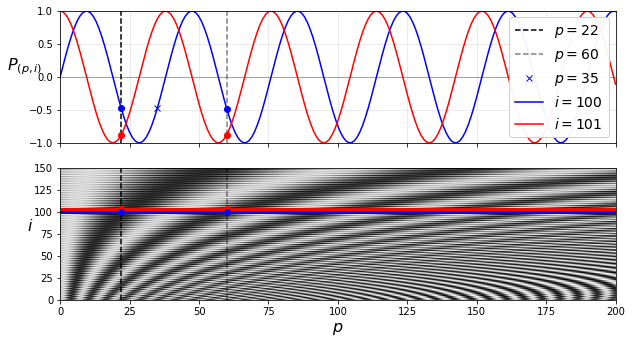

In [ ]:
# extra code – this cells generates and saves Figure 16–9
figure_max_length = 201
figure_embed_size = 512
pos_emb = PositionalEncoding(figure_max_length, figure_embed_size)
zeros = np.zeros((1, figure_max_length, figure_embed_size), np.float32)
P = pos_emb(zeros)[0].numpy()
i1, i2, crop_i = 100, 101, 150
p1, p2, p3 = 22, 60, 35
fig, (ax1, ax2) = plt.subplots(nrows=2, ncols=1, sharex=True, figsize=(9, 5))
ax1.plot([p1, p1], [-1, 1], "k--", label="$p = {}$".format(p1))
ax1.plot([p2, p2], [-1, 1], "k--", label="$p = {}$".format(p2), alpha=0.5)
ax1.plot(p3, P[p3, i1], "bx", label="$p = {}$".format(p3))
ax1.plot(P[:,i1], "b-", label="$i = {}$".format(i1))
ax1.plot(P[:,i2], "r-", label="$i = {}$".format(i2))
ax1.plot([p1, p2], [P[p1, i1], P[p2, i1]], "bo")
ax1.plot([p1, p2], [P[p1, i2], P[p2, i2]], "ro")
ax1.legend(loc="center right", fontsize=14, framealpha=0.95)
ax1.set_ylabel("$P_{(p,i)}$", rotation=0, fontsize=16)
ax1.grid(True, alpha=0.3)
ax1.hlines(0, 0, figure_max_length - 1, color="k", linewidth=1, alpha=0.3)
ax1.axis([0, figure_max_length - 1, -1, 1])
ax2.imshow(P.T[:crop_i], cmap="gray", interpolation="bilinear", aspect="auto")
ax2.hlines(i1, 0, figure_max_length - 1, color="b", linewidth=3)
cheat = 2  # need to raise the red line a bit, or else it hides the blue one
ax2.hlines(i2+cheat, 0, figure_max_length - 1, color="r", linewidth=3)
ax2.plot([p1, p1], [0, crop_i], "k--")
ax2.plot([p2, p2], [0, crop_i], "k--", alpha=0.5)
ax2.plot([p1, p2], [i2+cheat, i2+cheat], "ro")
ax2.plot([p1, p2], [i1, i1], "bo")
ax2.axis([0, figure_max_length - 1, 0, crop_i])
ax2.set_xlabel("$p$", fontsize=16)
ax2.set_ylabel("$i$", rotation=0, fontsize=16)
save_fig("positional_embedding_plot")
plt.show()

### Multi-Head Attention

In [ ]:
N = 2  # instead of 6
num_heads = 8
dropout_rate = 0.1
n_units = 128  # for the first Dense layer in each Feed Forward block
encoder_pad_mask = tf.math.not_equal(encoder_input_ids, 0)[:, tf.newaxis]
Z = encoder_in
for _ in range(N):
    skip = Z
    attn_layer = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_size, dropout=dropout_rate)
    Z = attn_layer(Z, value=Z, attention_mask=encoder_pad_mask)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))
    skip = Z
    Z = tf.keras.layers.Dense(n_units, activation="relu")(Z)
    Z = tf.keras.layers.Dense(embed_size)(Z)
    Z = tf.keras.layers.Dropout(dropout_rate)(Z)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))

In [ ]:
decoder_pad_mask = tf.math.not_equal(decoder_input_ids, 0)[:, tf.newaxis]
causal_mask = tf.linalg.band_part(  # creates a lower triangular matrix
    tf.ones((batch_max_len_dec, batch_max_len_dec), tf.bool), -1, 0)

In [ ]:
encoder_outputs = Z  # let's save the encoder's final outputs
Z = decoder_in  # the decoder starts with its own inputs
for _ in range(N):
    skip = Z
    attn_layer = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_size, dropout=dropout_rate)
    Z = attn_layer(Z, value=Z, attention_mask=causal_mask & decoder_pad_mask)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))
    skip = Z
    attn_layer = tf.keras.layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=embed_size, dropout=dropout_rate)
    Z = attn_layer(Z, value=encoder_outputs, attention_mask=encoder_pad_mask)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))
    skip = Z
    Z = tf.keras.layers.Dense(n_units, activation="relu")(Z)
    Z = tf.keras.layers.Dense(embed_size)(Z)
    Z = tf.keras.layers.LayerNormalization()(tf.keras.layers.Add()([Z, skip]))

**Warning**: the following cell will take a while to run (possibly 2 or 3 hours if you are not using a GPU).

In [ ]:
Y_proba = tf.keras.layers.Dense(vocab_size, activation="softmax")(Z)
model = tf.keras.Model(inputs=[encoder_inputs, decoder_inputs],
                       outputs=[Y_proba])
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam",
              metrics=["accuracy"])
model.fit((X_train, X_train_dec), Y_train, epochs=10,
          validation_data=((X_valid, X_valid_dec), Y_valid))

Epoch 1/10
250/250 [==============================] - 27s 55ms/step - loss: 2.8313 - accuracy: 0.1550 - val_loss: 2.6690 - val_accuracy: 0.1935
Epoch 2/10
250/250 [==============================] - 13s 51ms/step - loss: 2.4796 - accuracy: 0.2157 - val_loss: 2.5205 - val_accuracy: 0.2275
Epoch 3/10
250/250 [==============================] - 13s 51ms/step - loss: 2.3365 - accuracy: 0.2424 - val_loss: 2.4461 - val_accuracy: 0.2492
Epoch 4/10
250/250 [==============================] - 13s 52ms/step - loss: 2.2584 - accuracy: 0.2566 - val_loss: 2.4281 - val_accuracy: 0.2560
Epoch 5/10
250/250 [==============================] - 13s 52ms/step - loss: 2.1925 - accuracy: 0.2658 - val_loss: 2.3904 - val_accuracy: 0.2604
Epoch 6/10
250/250 [==============================] - 13s 50ms/step - loss: 2.1331 - accuracy: 0.2748 - val_loss: 2.3824 - val_accuracy: 0.2674
Epoch 7/10
250/250 [==============================] - 13s 50ms/step - loss: 2.0845 - accuracy: 0.2810 - val_loss: 2.3763 - val_accuracy:

In [ ]:
model.evaluate((X_test,X_test_dec),Y_test,batch_size=32)

In [ ]:
translate("I like soccer and also going to the beach")

'i m not [UNK] [UNK] [UNK] [UNK]'

# HuggingFace

In [8]:
!pip install -q -U transformers
!pip install -q -U datasets
!pip install -q -U rouge-score

In [9]:
import pyarrow as pa
import pandas as pd
from datasets import Dataset

train_dic={'input':sentences_en[:4000000],'output':sentences_es[:4000000]}
val_dic={'input':sentences_en[4000000:4500000],'output':sentences_es[4000000:4500000]}
test_dic={'input':sentences_en[4500000:],'output':sentences_es[4500000:]}

train_df=pd.DataFrame(train_dic)
val_df=pd.DataFrame(val_dic)
test_df=pd.DataFrame(test_dic)

hg_traind=Dataset(pa.Table.from_pandas(train_df))
hg_vald=Dataset(pa.Table.from_pandas(val_df))
hg_testd=Dataset(pa.Table.from_pandas(test_df))

In [10]:
from datasets import DatasetDict

raw_dataset=DatasetDict()
raw_dataset['train']=hg_traind
raw_dataset['validation']=hg_vald
raw_dataset['test']=hg_testd

In [11]:
del sentences_en ,sentences_es ,train_dic ,val_dic ,test_dic ,train_df ,val_df ,test_df ,hg_traind ,hg_vald ,hg_testd

In [12]:
raw_dataset

DatasetDict({
    train: Dataset({
        features: ['input', 'output'],
        num_rows: 4000000
    })
    validation: Dataset({
        features: ['input', 'output'],
        num_rows: 500000
    })
    test: Dataset({
        features: ['input', 'output'],
        num_rows: 500000
    })
})

In [13]:
raw_dataset['train'][0]

{'input': 'The debtor institution is consequently obliged to accept the information on which the claim is based and to reimburse the claim .',
 'output': 'The debtor institution is subsequently required to accept the information on which the claim is based and to pay it .'}

In [14]:
import datasets
import random
import pandas as pd
from IPython.display import display, HTML

def show_random_elements(dataset, num_examples=5):
    assert num_examples <= len(dataset), "Can't pick more elements than there are in the dataset."
    picks = []
    for _ in range(num_examples):
        pick = random.randint(0, len(dataset)-1)
        while pick in picks:
            pick = random.randint(0, len(dataset)-1)
        picks.append(pick)
    
    df = pd.DataFrame(dataset[picks])
    for column, typ in dataset.features.items():
        if isinstance(typ, datasets.ClassLabel):
            df[column] = df[column].transform(lambda i: typ.names[i])
    display(HTML(df.to_html()))

show_random_elements(raw_dataset["train"])

,input,output
0,Yongkang .,to Yongkang .
1,An unexpected error occurred while granting the Domain Administrators rights to administer the server object % 1 .,an unexpected error occurred during the grant of rights to domain administrators to manage the server object % 1 .
2,"If both parents share custody , either of them may at any time petition for that joint custody to be revoked .","If the parents have joint custody , either of them may at any time petition for the annulment of joint custody ."
3,"( e ) expenditure implemented as part of shared , decentralised or joint management within the meaning of Article 53 ;","( e ) expenditure effected under shared , decentralised or joint management within the meaning of Article 53 of this Regulation ;"
4,The system led to an accumulation of debt .,the system led to the accumulation of debts .


In [15]:
from datasets import load_metric
metric = load_metric("rouge")

In [16]:
fake_preds = ["hello there", "general kenobi"]
fake_labels = ["hello there", "general kenobi"]
metric.compute(predictions=fake_preds, references=fake_labels)

{'rouge1': AggregateScore(low=Score(precision=1.0, recall=1.0, fmeasure=1.0), mid=Score(precision=1.0, recall=1.0, fmeasure=1.0), high=Score(precision=1.0, recall=1.0, fmeasure=1.0)),
 'rouge2': AggregateScore(low=Score(precision=1.0, recall=1.0, fmeasure=1.0), mid=Score(precision=1.0, recall=1.0, fmeasure=1.0), high=Score(precision=1.0, recall=1.0, fmeasure=1.0)),
 'rougeL': AggregateScore(low=Score(precision=1.0, recall=1.0, fmeasure=1.0), mid=Score(precision=1.0, recall=1.0, fmeasure=1.0), high=Score(precision=1.0, recall=1.0, fmeasure=1.0)),
 'rougeLsum': AggregateScore(low=Score(precision=1.0, recall=1.0, fmeasure=1.0), mid=Score(precision=1.0, recall=1.0, fmeasure=1.0), high=Score(precision=1.0, recall=1.0, fmeasure=1.0))}

In [17]:
model_checkpoint = "t5-small"

from transformers import AutoTokenizer
    
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

/usr/local/lib/python3.7/dist-packages/transformers/models/t5/tokenization_t5_fast.py:166: FutureWarning: This tokenizer was incorrectly instantiated with a model max length of 512 which will be corrected in Transformers v5.
For now, this behavior is kept to avoid breaking backwards compatibility when padding/encoding with `truncation is True`.
- Be aware that you SHOULD NOT rely on t5-small automatically truncating your input to 512 when padding/encoding.
- If you want to encode/pad to sequences longer than 512 you can either instantiate this tokenizer with `model_max_length` or pass `max_length` when encoding/padding.
- To avoid this warning, please instantiate this tokenizer with `model_max_length` set to your preferred value.
  FutureWarning,


In [18]:
tokenizer("Hello, this one sentence!")

{'input_ids': [8774, 6, 48, 80, 7142, 55, 1], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [19]:
tokenizer(["Hello, this one sentence!", "This is another sentence."])

{'input_ids': [[8774, 6, 48, 80, 7142, 55, 1], [100, 19, 430, 7142, 5, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]}

In [20]:
with tokenizer.as_target_tokenizer():
    print(tokenizer(["Hello, this one sentence!", "This is another sentence."]))

{'input_ids': [[8774, 6, 48, 80, 7142, 55, 1], [100, 19, 430, 7142, 5, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1]]}


In [21]:
prefix = "paraphrase: "

In [22]:
max_input_length = 300
max_target_length = 300

def preprocess_function(examples):
    inputs = [prefix + doc for doc in examples["input"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True)

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["output"], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

In [23]:
preprocess_function(raw_dataset['train'][:2])

{'input_ids': [[3856, 27111, 10, 37, 2814, 127, 6568, 19, 21612, 120, 19880, 26, 12, 1845, 8, 251, 30, 84, 8, 1988, 19, 3, 390, 11, 12, 29560, 8, 1988, 3, 5, 1], [3856, 27111, 10, 94, 3, 31, 7, 705, 10875, 145, 8, 336, 360, 648, 3, 5, 1]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]], 'labels': [[37, 2814, 127, 6568, 19, 3, 14064, 831, 12, 1845, 8, 251, 30, 84, 8, 1988, 19, 3, 390, 11, 12, 726, 34, 3, 5, 1], [94, 3, 31, 7, 705, 10875, 145, 336, 97, 3, 5, 1]]}

In [24]:
tokenized_datasets = raw_dataset.map(preprocess_function, batched=True)

Parameter 'function'=<function preprocess_function at 0x7fb1b41d9e60> of the transform datasets.arrow_dataset.Dataset._map_single couldn't be hashed properly, a random hash was used instead. Make sure your transforms and parameters are serializable with pickle or dill for the dataset fingerprinting and caching to work. If you reuse this transform, the caching mechanism will consider it to be different from the previous calls and recompute everything. This warning is only showed once. Subsequent hashing failures won't be showed.


  0%|          | 0/4000 [00:00<?, ?ba/s]

  0%|          | 0/500 [00:00<?, ?ba/s]

  0%|          | 0/500 [00:00<?, ?ba/s]

In [25]:
del raw_dataset

In [26]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer

model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [27]:
batch_size = 32
model_name = model_checkpoint.split("/")[-1]

args = Seq2SeqTrainingArguments(
    f"{model_name}-finetuned-xsum",
    evaluation_strategy="steps",
    eval_steps=100,
    logging_strategy="steps",
    logging_steps=100,
    save_strategy="steps",
    save_steps=200,
    learning_rate=4e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=1,
    predict_with_generate=True,
    load_best_model_at_end=True,
    metric_for_best_model="rouge1",
)

"""
args = Seq2SeqTrainingArguments(
    f"{model_name}-finetuned-xsum-new",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    weight_decay=0.01,
    save_total_limit=3,
    num_train_epochs=1,
    predict_with_generate=True,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="rouge1"
)"""

'\nargs = Seq2SeqTrainingArguments(\n    f"{model_name}-finetuned-xsum-new",\n    evaluation_strategy = "epoch",\n    learning_rate=2e-5,\n    per_device_train_batch_size=batch_size,\n    per_device_eval_batch_size=batch_size,\n    weight_decay=0.01,\n    save_total_limit=3,\n    num_train_epochs=1,\n    predict_with_generate=True,\n    fp16=True,\n    load_best_model_at_end=True,\n    metric_for_best_model="rouge1"\n)'

In [28]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

In [29]:
import nltk
nltk.download('punkt')

import numpy as np

def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]
    
    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    # Extract a few results
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}
    
    # Add mean generated length
    prediction_lens = [np.count_nonzero(pred != tokenizer.pad_token_id) for pred in predictions]
    result["gen_len"] = np.mean(prediction_lens)
    
    return {k: round(v, 4) for k, v in result.items()}

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [30]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['validation'],
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [31]:
def model_init():
    return AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

In [43]:
!nvidia-smi

Sun Jul  3 03:38:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   63C    P0    29W /  70W |  15106MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [32]:
trainer.train()

The following columns in the training set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: input, output. If input, output are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:310: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,
***** Running training *****
  Num examples = 4000000
  Num Epochs = 1
  Instantaneous batch size per device = 32
  Total train batch size (w. parallel, distributed & accumulation) = 32
  Gradient Accumulation steps = 1
  Total optimization steps = 125000


Step,Training Loss,Validation Loss


KeyboardInterrupt: ignored

In [ ]:
model_dir = "/content/t5-small-finetuned-xsum/checkpoint-400"

tokenizer = AutoTokenizer.from_pretrained(model_dir)
model = AutoModelForSeq2SeqLM.from_pretrained(model_dir)

max_input_length = 300

Didn't find file /content/t5-small-finetuned-xsum/checkpoint-400/spiece.model. We won't load it.
Didn't find file /content/t5-small-finetuned-xsum/checkpoint-400/added_tokens.json. We won't load it.
loading file None
loading file /content/t5-small-finetuned-xsum/checkpoint-400/tokenizer.json
loading file None
loading file /content/t5-small-finetuned-xsum/checkpoint-400/special_tokens_map.json
loading file /content/t5-small-finetuned-xsum/checkpoint-400/tokenizer_config.json
loading configuration file /content/t5-small-finetuned-xsum/checkpoint-400/config.json
Model config T5Config {
  "_name_or_path": "/content/t5-small-finetuned-xsum/checkpoint-400",
  "architectures": [
    "T5ForConditionalGeneration"
  ],
  "d_ff": 2048,
  "d_kv": 64,
  "d_model": 512,
  "decoder_start_token_id": 0,
  "dense_act_fn": "relu",
  "dropout_rate": 0.1,
  "eos_token_id": 1,
  "feed_forward_proj": "relu",
  "initializer_factor": 1.0,
  "is_encoder_decoder": true,
  "is_gated_act": false,
  "layer_norm_eps

In [ ]:
text = "I will be showing you how to build a web application in Python"

inputs = ["paraphrase: " + text]

inputs = tokenizer(inputs, max_length=max_input_length, truncation=True, return_tensors="pt")
output = model.generate(**inputs, num_beams=8, do_sample=True, min_length=10, max_length=100,num_return_sequences=5)
decoded_output = tokenizer.batch_decode(output, skip_special_tokens=True)

for ph in decoded_output:
    predicted = nltk.sent_tokenize(ph.strip())
    print(predicted)

['I will show you how to build a web application in Python.']
['I will show you how to build a web application in Python.']
['I will show you how to build a web application in Python.']
['I will show you how to build a web application in Python.']
['I will show you how to build a web application in Python.']


In [ ]:
trainer.evaluate(tokenized_datasets['test'])

The following columns in the evaluation set don't have a corresponding argument in `T5ForConditionalGeneration.forward` and have been ignored: input, output. If input, output are not expected by `T5ForConditionalGeneration.forward`,  you can safely ignore this message.
***** Running Evaluation *****
  Num examples = 1000
  Batch size = 16


{'epoch': 1.0,
 'eval_gen_len': 14.374,
 'eval_loss': 1.0254814624786377,
 'eval_rouge1': 72.2145,
 'eval_rouge2': 51.6849,
 'eval_rougeL': 70.7002,
 'eval_rougeLsum': 70.6978,
 'eval_runtime': 24.2999,
 'eval_samples_per_second': 41.152,
 'eval_steps_per_second': 2.593}